In [1]:
import os
import sys
sys.path.append('utils')
from tqdm import tqdm, trange
import pandas as pd
import numpy as np
from pandas.tseries.offsets import Day, Minute, Hour
from statsmodels.tsa.arima_model import ARIMA
import math
import types
from dataset.spot import SlidingWindow, SPOT
from utils.tool import picp, mpiw, rpiw, cwc
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def mae(pred, y_true, mode='default'):
    if mode == 'max':
        out = np.abs(pred.reshape(-1, 24).max(axis=-1) - y_true.reshape(-1, 24).max(axis=-1)).mean()
    elif mode == 'min':
        out = np.abs(pred.reshape(-1, 24).min(axis=-1) - y_true.reshape(-1, 24).min(axis=-1)).mean()
    else:
        out = np.abs(pred - y_true).mean()
    return out

def rmse(pred, y_true):
    out = np.power((pred - y_true), 2).mean()
    return math.sqrt(out)

In [3]:
def mape(pred, y_true, threshold=1e-2):
    pred.reshape(y_true.shape)
    f = lambda o,c: (math.fabs((o-c) / float(o)))*1.0 if math.fabs(o) > threshold else np.nan
    f = np.vectorize(f)
    error = f(y_true, pred)    
    errorCnts = error.shape[0]-np.sum(np.isnan(error),axis=0)
    error = np.nan_to_num(error)
    return np.sum(error, axis=0) / errorCnts

In [4]:
# Naïve version
y = SPOT['2016':'2016-06-30'].values
y_hat = SPOT['2015-12-31':'2016-06-29'].values

In [7]:
mae(y, y_hat), mae(y, y_hat, mode='max'), mae(y, y_hat, mode='min'), rmse(y, y_hat), mape(y, y_hat)

(5.734949633699634,
 6.491813186813187,
 4.7904945054945065,
 7.988578737626158,
 0.330099122952231)

In [8]:
# direct prediction

In [9]:
# load dataset
data = SPOT['2015':'2016-06-30'].values

pred = []

step=0
for _ in trange(182):
    train = data[step*24:-(182-step)*24][-30*24:]
    # fit model
    model = ARIMA(train, order=(5,1,0))
    model_fit = model.fit(disp=0)
    forecast = model_fit.forecast(steps=24)[0]
    pred.append(forecast)
    step += 1
    

  0%|          | 0/182 [00:00<?, ?it/s]/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

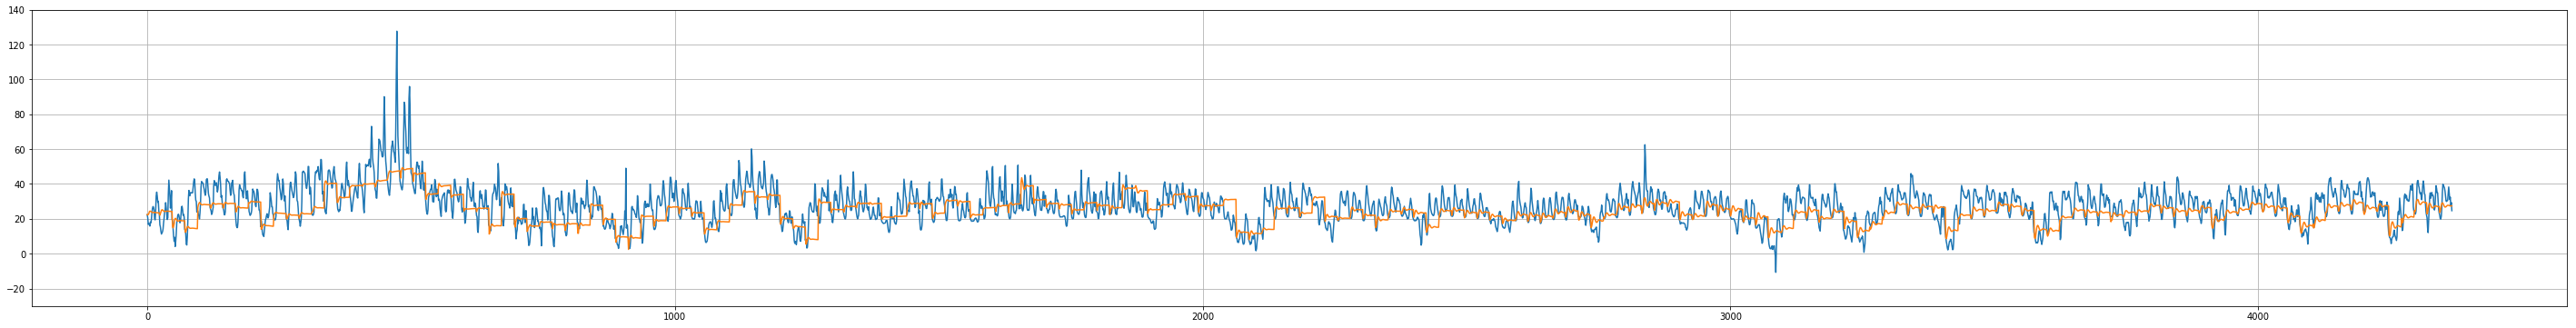

In [11]:
pred = np.array(pred).reshape(182*24)
Y = SPOT['2016':'2016-06-30'].values
# plot
plt.figure(figsize=(50,6))
plt.plot(Y)
plt.plot(pred)
plt.ylim(-30,140)
plt.grid()

In [12]:
mae(pred, Y), mae(pred, Y, mode='max'), mae(pred, Y, mode='min'), rmse(pred, Y), mape(pred, Y)

(6.664404919914506,
 13.209737985353634,
 5.690280016679148,
 8.649776754898037,
 0.28535279775035194)

In [4]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [5]:
# diff-version

In [6]:
# load dataset
data0 = SPOT['2015-12-01':'2016-06-30'].values
# m = min(data0)
# data = np.log2(data0-m+1)
# data[11848]=1.1
data=data0

X = data[:-182*24]
Y = data0[-182*24:]

# seasonal difference

hours_in_day = 24
hours_in_week = 168
diff = difference(data, hours_in_day)
# diff_X = np.clip(difference(diff, hours_in_week), -0.2, 0.2)
diff_X = difference(diff, hours_in_week)


In [65]:
pred = []
pi95 = []
pi99 = []
step=0
for _ in trange(182):
    train = diff_X[:-(182-step)*24][-30*24:]
    # fit model
    model = ARIMA(train, order=(5,0,0))
    model_fit = model.fit(disp=0)
    forecast95 = model_fit.forecast(steps=24,alpha=0.05)
    forecast99 = model_fit.forecast(steps=24,alpha=0.01)
    y_hat = data[-(182-step+1)*24:-(182-step)*24] + diff[-(182-step+7)*24:-(182-step+6)*24] + forecast95[0]
    l95 = data[-(182-step+1)*24:-(182-step)*24] + diff[-(182-step+7)*24:-(182-step+6)*24] + forecast95[2][:,0]
    u95 = data[-(182-step+1)*24:-(182-step)*24] + diff[-(182-step+7)*24:-(182-step+6)*24] + forecast95[2][:,1]
    l99 = data[-(182-step+1)*24:-(182-step)*24] + diff[-(182-step+7)*24:-(182-step+6)*24] + forecast99[2][:,0]
    u99 = data[-(182-step+1)*24:-(182-step)*24] + diff[-(182-step+7)*24:-(182-step+6)*24] + forecast99[2][:,1]
    pred.append(y_hat)
    pi95.append([l95, u95])
    pi99.append([l99, u99])
    step += 1
    

  0%|          | 0/182 [00:00<?, ?it/s]/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

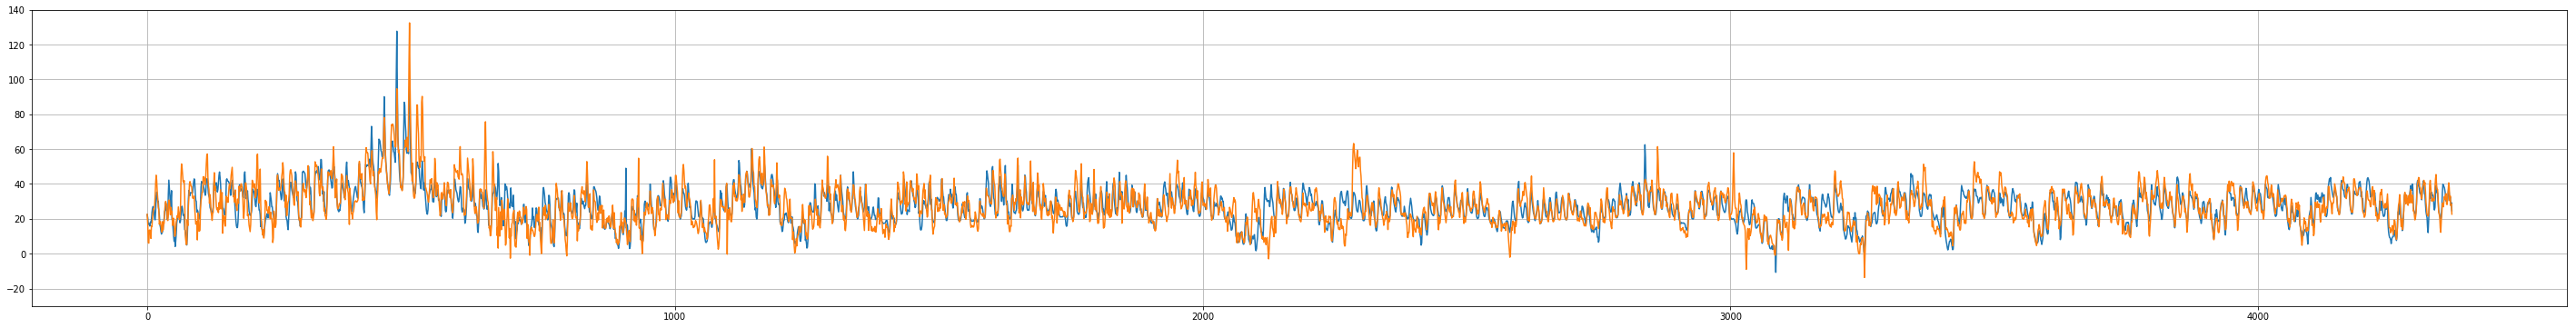

In [66]:
pred = np.array(pred).reshape(182*24)
# plot
plt.figure(figsize=(50,6))
plt.plot(Y)
plt.plot(pred)
plt.ylim(-30,140)
plt.grid()

In [67]:
mae(pred, Y), mae(pred, Y, mode='max'), mae(pred, Y, mode='min'), rmse(pred, Y), mape(pred, Y)

(5.060274091418395,
 6.504665996685396,
 4.013033223899882,
 7.132282285001701,
 0.21872007856978243)

In [68]:
# order=(3,0,0)
# (5.070870960980965, 6.477646435400403, 4.016734263859024, 7.149342037222711)
# order=(5,0,0)
# (5.060274091418395, 6.504665996685396, 4.013033223899882, 7.132282285001701)
# order=(7,0,0)
# (5.066446512233688, 6.536708204412742, 4.043478339286173, 7.147334401068589)
# order=(9,0,0)
# (5.10466705239823, 6.596807198759356, 4.106208298434005, 7.178601856153058)

In [69]:
# Prediction Intervals

In [78]:
pi=np.array(pi99)

In [79]:
l=pi[:,0,:].reshape(182*24)
u=pi[:,1,:].reshape(182*24)

In [80]:
# save bounds
bounds = np.stack((l, u))
np.save('./bounds/arima_99.npy', bounds)

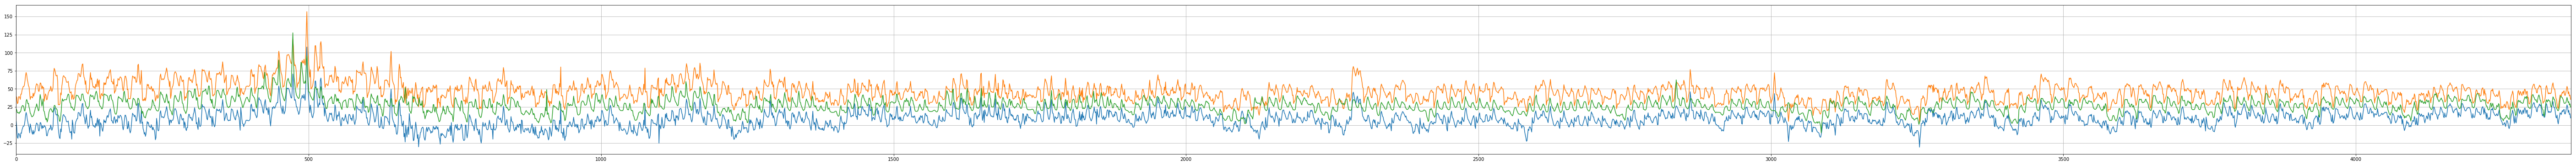

In [81]:
plt.figure(figsize=(100,6))
plt.plot(l)
plt.plot(u)
plt.plot(Y)
plt.xlim(0, 182*24)
plt.grid()

In [82]:
picp(Y, l, u)

0.9793956043956044

In [83]:
mpiw(Y, l, u), mpiw(Y, l, u, 1)

(37.77303512580752, 0.2730449264551649)

In [84]:
rpiw(Y, l, u), rpiw(Y, l, u, 1)

(38.860778330596276, 0.28090775141388086)

In [85]:
cwc(Y, l, u), cwc(Y, l, u, alpha=0.01)

(0.2730449264551649, 0.7370317376323203)

In [20]:
# rolling

In [27]:
# load dataset
data = SPOT['2015-12-01':'2016-08-31'].values

X = data[:-182*24]
Y = data0[-182*24:]

# seasonal difference

hours_in_day = 24
hours_in_week = 168
diff = difference(data, hours_in_day)
# diff_X = np.clip(difference(diff, hours_in_week), -0.2, 0.2)
diff_X = difference(diff, hours_in_week)

In [28]:
pred = []

train = diff_X[-244*24:-62*24]
# fit model
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit(disp=0)
forecast = model_fit.forecast(steps=24*62)[0]
y_hat = data[-(182+62)*24:-182*24] + diff[-(182+68)*24:-(182+6)*24] + forecast

/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr

In [29]:
y_hat.shape

(1488,)

In [30]:
Y=SPOT['2016-07-01':'2016-08-31'].values

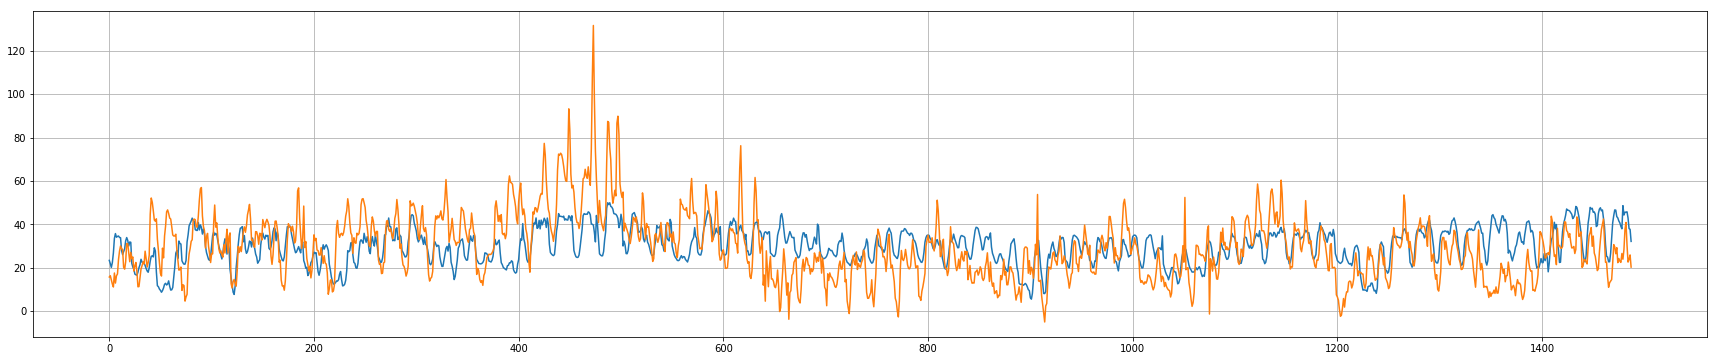

In [31]:
# plot
plt.figure(figsize=(30,6))
plt.plot(Y)
plt.plot(y_hat)
plt.grid()

In [32]:
mae(y_hat, Y), mae(y_hat, Y, mode='max'), mae(y_hat, Y, mode='min'), rmse(y_hat, Y)

(10.446766240468643, 14.150662415690192, 9.337750266078466, 13.553132628089982)

In [46]:
mae(y_hat[:14*24], Y[:14*24]), rmse(y_hat[:14*24], Y[:14*24])

(9.343190993928893, 12.07494299493451)